# Classification

## Objectives

*  Fit and evaluate a classification model to predict if a prospect will churn or not.

## Inputs

* outputs/datasets/collection/TelcoCustomerChurn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in each respective notebook.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot



---

# Change working directory

Change the working directory from its current folder to its parent folder


In [29]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Film_Hit_prediction'

Make the parent of the current directory the new current directory.


In [30]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [31]:
current_dir = os.getcwd()
current_dir

'/workspace'

---

# Load Data 

Load Data

In [32]:
import pandas as pd
import pickle

# Load the splits for modeling
X_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_train.pkl')
X_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl')
y_train = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl')
y_test = pd.read_pickle('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl')


print("Dataset shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


Dataset shapes:
X_train shape: (813, 1354)
y_train shape: (813,)
X_test shape: (3284, 1354)
y_test shape: (3284,)


---

# Step 2: ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

In [33]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define models

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
        }
    },
 
}


# Set up and train model

In [34]:


results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")

    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs= 2
    )
    
    grid_search.fit(X_train, y_train)



Training Linear Regression...

Training Ridge...

Training Lasso...

Training Random Forest...


# Train Models and Evaluate Performance

In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

results = {}
best_models = {}

for name, model_info in models.items():
    print(f"\nTraining {name}...")
    
    # GridSearchCV performs the hyperparameter optimization
    grid_search = GridSearchCV(
        model_info['model'],
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=2
    )
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Store the best model and make predictions
    best_models[name] = grid_search.best_estimator_
    y_pred = grid_search.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2,
        'Best Parameters': grid_search.best_params_
    }
    
    # Print results
    print(f"\nResults for {name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Best Parameters: {grid_search.best_params_}")


Training Linear Regression...

Results for Linear Regression:
RMSE: 62979898174.27
R2 Score: -3966467574041311444992.00
Best Parameters: {}

Training Ridge...

Results for Ridge:
RMSE: 0.71
R2 Score: 0.50
Best Parameters: {'alpha': 10.0}

Training Lasso...

Results for Lasso:
RMSE: 0.64
R2 Score: 0.59
Best Parameters: {'alpha': 0.1}

Training Random Forest...

Results for Random Forest:
RMSE: 0.59
R2 Score: 0.66
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


# Save Best Performing Model

In [36]:
import os
import joblib

best_model = None
best_score = float('-inf')

# Find the best model based on R2 score
for name, metrics in results.items():
    if metrics['R2 Score'] > best_score:
        best_score = metrics['R2 Score']
        best_model = best_models[name]


# Save the best model using joblib
joblib.dump(best_model, '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib')

print("Best model saved successfully!")


Best model saved successfully!


## Assess feature importance

Loaded model type: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

Top 10 Most Important Features:
                     Feature  Importance
1239                  budget    0.596879
487               popularity    0.176497
399                  runtime    0.064591
838        budget_per_minute    0.032197
391   company_DreamWorks SKG    0.012953
1059       other_actor_count    0.009752
1240    other_producer_count    0.006264
466        company_Lucasfilm    0.004710
469     other_director_count    0.003148
492                    Drama    0.002872


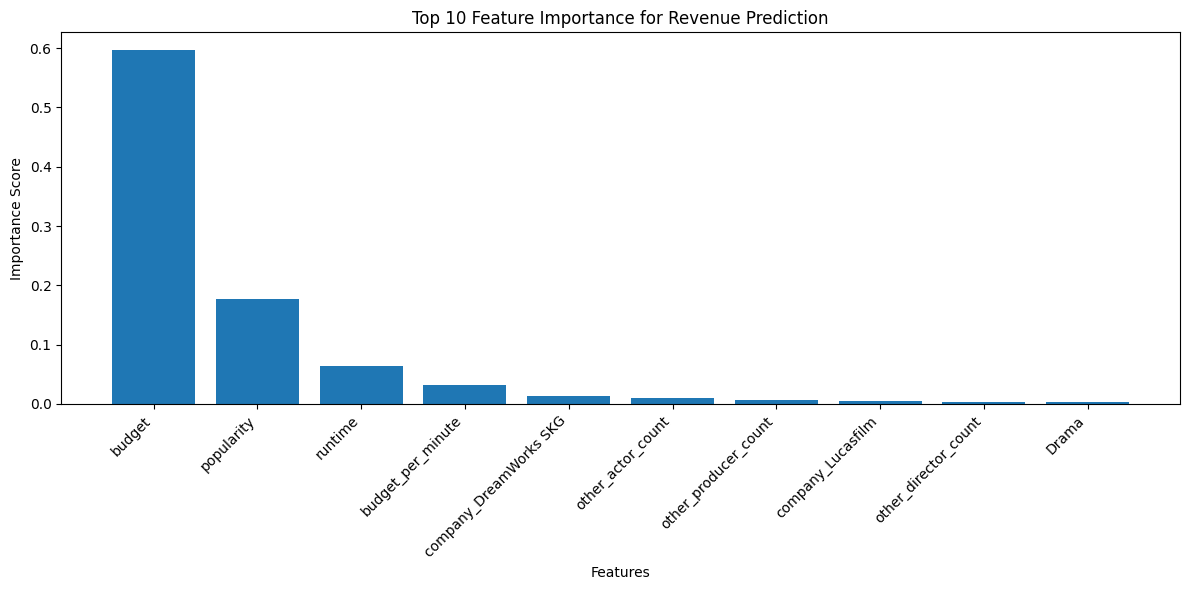

In [37]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved Random Forest model
model_path = '/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib'
loaded_model = joblib.load(model_path)

print("Loaded model type:", type(loaded_model))


# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': loaded_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Print top 10 most important features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot the top 10 feature importance
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance for Revenue Prediction')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


# Prediction Model


Create a function to make predictions for new movies based on parameters:
-  budget (float): Movie budget in dollars
- language (str): Original language (e.g., 'en' for English)
- genres (list): List of genres (e.g., ['Action', 'Adventure'])
    
 Returns:
- float: Predicted revenue and profit

New model

In [38]:
import pandas as pd
import numpy as np
import pickle
import joblib
from sklearn.preprocessing import StandardScaler


# First load all necessary models and data
def load_models_and_data():
    """
    Load all necessary models, encoders, and data files
    """
    try:
        print("Loading models and data...")
        
        # Load the trained model
        print("Loading revenue prediction model...")
        model = joblib.load('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/film_revenue_model.joblib')
        print("Model loaded successfully!")
        
        # Load the training and test data
        print("Loading training and test data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/train_df_engineered.pkl', 'rb') as f:
            train_df = pickle.load(f)
            
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/test_df_engineered.pkl', 'rb') as f:
            test_df = pickle.load(f)
            
        # Load encoders and filters
        print("Loading encoders...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/cleaned/encoders_and_filters.pkl', 'rb') as f:
            encoders = pickle.load(f)

        # Load feature engineering data
        print("Loading feature engineering data...")
        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/feature_engineering_data.pkl', 'rb') as f:
            eng_data = pickle.load(f)

        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/all_features.pkl', 'rb') as f:
            all_features = pickle.load(f)
            features = {col: 0 for col in all_features}

        with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/feature_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
            
        print("All models and data loaded successfully!")
        
        return {
            'train_df': train_df,
            'test_df': test_df,
            'encoders': encoders,
            'eng_data': eng_data,
            'model': model,
            'feature_names': train_df.columns
        }
    except Exception as e:
        print(f"Error loading models and data: {str(e)}")
        print("Error details:")
        import traceback
        traceback.print_exc()
        return None
    
    # Load all models and data once
print("Initializing prediction system...")
MODELS_AND_DATA = load_models_and_data()

Initializing prediction system...
Loading models and data...
Loading revenue prediction model...
Model loaded successfully!
Loading training and test data...
Loading encoders...
Loading feature engineering data...
All models and data loaded successfully!


In [39]:
def predict_movie_revenue(
    budget,
    runtime,
    genres,  
    language,
    production_company,
    production_country,
    actor1,
    actor2,
    crew_director,
    crew_writer,
    crew_producer
):
    try:
        import traceback

        if MODELS_AND_DATA is None:
            raise ValueError("Models and data not properly loaded")
            
        # Unpack models and data
        train_df = MODELS_AND_DATA['train_df']
        encoders = MODELS_AND_DATA['encoders']
        eng_data = MODELS_AND_DATA['eng_data']
        model = MODELS_AND_DATA['model']
        feature_names = MODELS_AND_DATA['feature_names']
      
        
        print("\nDEBUG - Model Information:")
        print(f"Model type: {type(model).__name__}")
        print(f"Expected features: {len(feature_names)}")
        
        # Initialize features dictionary with ALL possible features
        features = {col: 0 for col in feature_names if col != 'revenue'}
        
        # Scale the numeric inputs using training data statistics
        std_budget = (budget - train_df['budget'].mean()) / train_df['budget'].std()
        budget_per_minute = budget / runtime if runtime > 0 else 0
        std_budget_per_minute = (budget_per_minute - train_df['budget_per_minute'].mean()) / train_df['budget_per_minute'].std()
        
        print("\nDEBUG - Scaled Inputs:")
        print(f"Original budget: ${budget:,.2f}")
        print(f"Scaled budget: {std_budget:.4f}")
        print(f"Original budget_per_minute: ${budget_per_minute:,.2f}")
        print(f"Scaled budget_per_minute: {std_budget_per_minute:.4f}")
        
        # Set scaled numeric features
        features['budget'] = std_budget
        features['popularity'] = 0  # Default for new movies
        features['runtime'] = runtime
        features['budget_per_minute'] = std_budget_per_minute

        # Set categorical features
        print("\nDEBUG - Setting categorical features:")
        if f'cast_{actor1}' in features:
            features[f'cast_{actor1}'] = 1
            print(f"Set {actor1}")
        if f'cast_{actor2}' in features:
            features[f'cast_{actor2}'] = 1
            print(f"Set {actor2}")
        
        if f'crew_director_{crew_director}' in features:
            features[f'crew_director_{crew_director}'] = 1
            print(f"Set director {crew_director}")
        
        if f'crew_writer_{crew_writer}' in features:
            features[f'crew_writer_{crew_writer}'] = 1
            print(f"Set writer {crew_writer}")
        
        if f'crew_producer_{crew_producer}' in features:
            features[f'crew_producer_{crew_producer}'] = 1
            print(f"Set producer {crew_producer}")
            
        if f'company_{production_company}' in features:
            features[f'company_{production_company}'] = 1
            print(f"Set company {production_company}")

        # Set genre features
        print("\nDEBUG - Setting genres:")
        for genre in genres:
            if genre in features:
                features[genre] = 1
                print(f"Set genre {genre}")

        # Create DataFrame and ensure all features are present
        pred_df = pd.DataFrame([features])
        
        # Explicitly reindex to match model's expected features
        expected_features = [col for col in feature_names if col != 'revenue']
        pred_df = pred_df.reindex(columns=expected_features, fill_value=0)
        
        print(f"\nDEBUG - Features shape after reindexing: {pred_df.shape}")
        print(f"Number of non-zero features: {(pred_df != 0).sum().sum()}")
        
        # Get prediction
        raw_prediction = model.predict(pred_df)[0]
        print(f"Raw scaled prediction: {raw_prediction}")
        
        # Unscale the prediction using training data statistics
        predicted_revenue = (raw_prediction * train_df['revenue'].std()) + train_df['revenue'].mean()
        predicted_revenue = max(0, predicted_revenue)
        
        return {
            'revenue': predicted_revenue,
            'profit': predicted_revenue - budget,
            'roi': ((predicted_revenue - budget) / budget * 100) if budget > 0 else 0,
            'is_profitable': predicted_revenue > budget
        }
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        traceback.print_exc()
        return None

In [40]:
# Example usage
if __name__ == "__main__":
    test_movie = {
        'budget': 150000000,
        'runtime': 120,
        'genres': ['Action'],
        'language': 'en',
        'production_company': 'Marvel Studios',
        'production_country': 'US',
        'actor1': 'Chris Hemsworth',
        'actor2': 'Robert Downey Jr.',
        'crew_director': 'Joss Whedon',
        'crew_writer': 'Joss Whedon',
        'crew_producer': 'Kevin Feige'
    }
    
    result = predict_movie_revenue(**test_movie)
    
    if result is not None:
        print(f"\nPredicted Revenue: ${result['revenue']:,.2f}")
        print(f"Predicted Profit/Loss: ${result['profit']:,.2f}")
        print(f"ROI: {result['roi']:.1f}%")
        print(f"Is Profitable: {'Yes' if result['is_profitable'] else 'No'}")


DEBUG - Model Information:
Model type: RandomForestRegressor
Expected features: 1355

DEBUG - Scaled Inputs:
Original budget: $150,000,000.00
Scaled budget: 149977160.2587
Original budget_per_minute: $1,250,000.00
Scaled budget_per_minute: 1249809.6688

DEBUG - Setting categorical features:
Set company Marvel Studios

DEBUG - Setting genres:
Set genre Action

DEBUG - Features shape after reindexing: (1, 1354)
Number of non-zero features: 5
Raw scaled prediction: -0.16467898599091896

Predicted Revenue: $0.00
Predicted Profit/Loss: $-150,000,000.00
ROI: -100.0%
Is Profitable: No


# Evaluation


Load model

In [43]:
import joblib

model_path = "/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/models/"  
model = joblib.load(model_path + 'film_revenue_model.joblib')

print("Model loaded:", type(model))


Model loaded: <class 'sklearn.ensemble._forest.RandomForestRegressor'>


Make predictions on test data 

In [60]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Load test and train data
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
    
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Load X_test if not already loaded
with open('/workspace/Film_Hit_prediction/jupyter_notebooks/outputs/engineered/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Get predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f'Root Mean Squared Error: ${rmse:,.2f}')
print(f'Mean Absolute Error: ${mae:,.2f}')
print(f'R² Score: {r2:.4f}')

# Calculate percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape:.2f}%')






Model Evaluation Metrics:
Root Mean Squared Error: $0.59
Mean Absolute Error: $0.27
R² Score: 0.6572
Mean Absolute Percentage Error: 218.82%


Visualizations

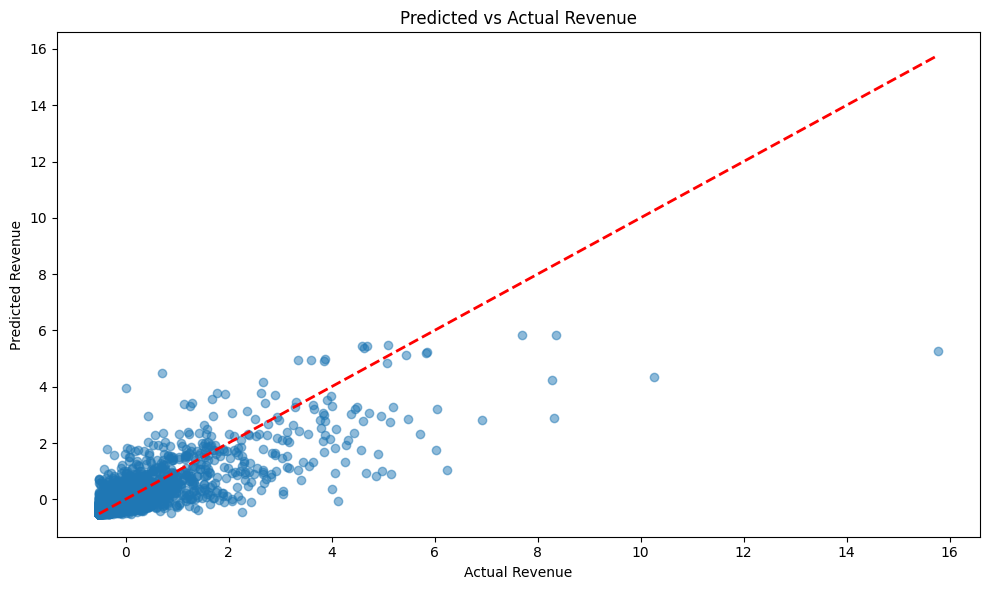

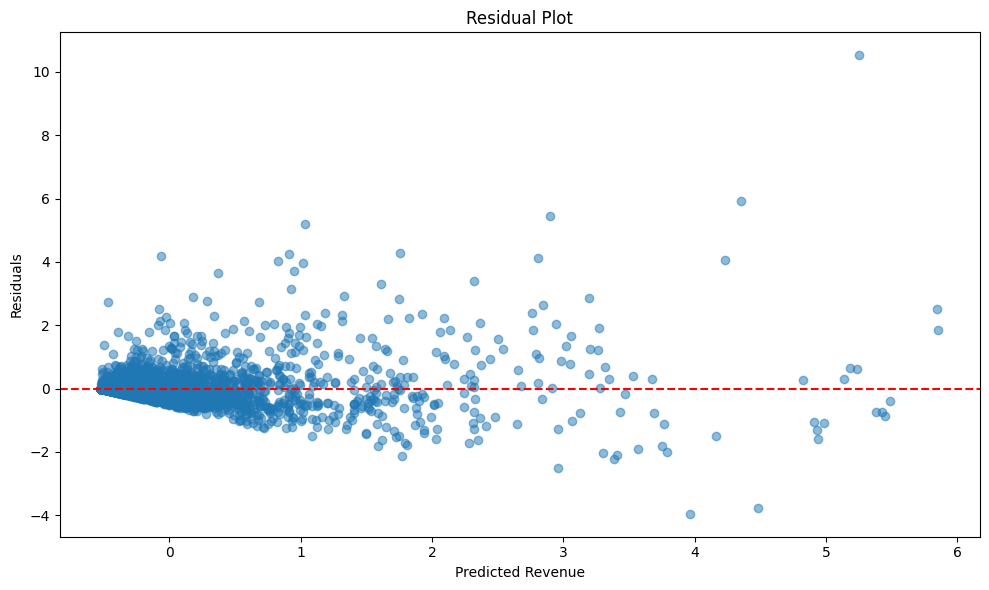

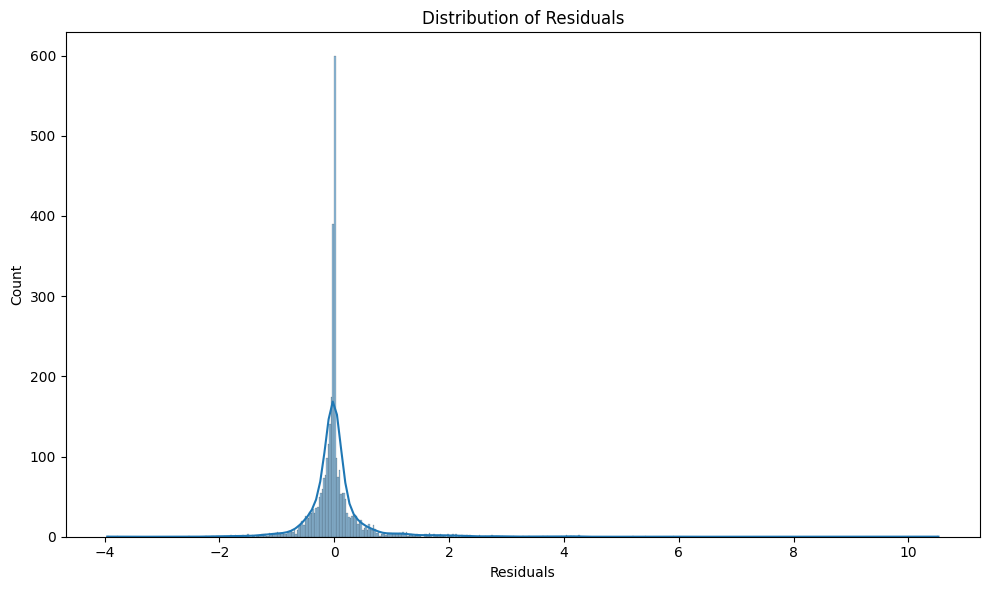

In [61]:
# Visualization of predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Revenue')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Revenue')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# Distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Distribution of Residuals')
plt.tight_layout()
plt.show()

Additional analysis

In [62]:


# Additional analysis
print("\nResiduals Analysis:")
print(f"Mean of residuals: ${residuals.mean():,.2f}")
print(f"Standard deviation of residuals: ${residuals.std():,.2f}")
print(f"Skewness of residuals: {residuals.skew():.2f}")

# Sample predictions
comparison_df = pd.DataFrame({
    'Actual Revenue': y_test,
    'Predicted Revenue': y_pred,
    'Absolute Error': np.abs(y_test - y_pred),
    'Percentage Error': np.abs((y_test - y_pred) / y_test) * 100
})

print("\nSample Predictions (first 5 movies):")
print(comparison_df.head().to_string())


Residuals Analysis:
Mean of residuals: $0.03
Standard deviation of residuals: $0.58
Skewness of residuals: 4.05

Sample Predictions (first 5 movies):
   Actual Revenue  Predicted Revenue  Absolute Error  Percentage Error
0       -0.367131          -0.484210        0.117078         31.890100
1       -0.514890          -0.514660        0.000231          0.044806
2       -0.475899          -0.363497        0.112402         23.618868
3       -0.312314          -0.352995        0.040681         13.025649
4       -0.479833          -0.441442        0.038391          8.000993
